In [1]:
%config Completer.use_jedi = False

from utils import *
from parallel import to_run, findpos, find_sigma_em

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import importlib
from multiprocessing import Pool
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

from ising_model import SimulateMH

from scipy import signal

In [2]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.figsize"] = [12,8]

In [3]:
TTc = 2/np.log(1+np.sqrt(2)); print(f"Tc = {TTc:0.3f}")

Tc = 2.269


In [4]:
N = 32
H = 1

In [5]:
def f(H, T, N, factor_omega = 1,periods=10, pass_low=False, pass_high=False, SEED=None):
    steps_needed = int(relaxation_time_normalized(T) * N * N)
    warmup = int(10*steps_needed)
    
    omega = 2*np.pi / (steps_needed) * factor_omega
    period = int(2*np.pi/omega)
    steps = warmup + int(period*(periods)); 
    steps = warmup + (steps-warmup)//10**5 * 10**5
    
    if pass_low == False:
        assert steps > 3e5, steps
    if pass_high == False:
        assert steps < 1e7, steps//1e7
    assert steps < 1e9
    
    freq=1
    
    _, _, Ms, Es, engine = to_run(0, 
       steps=steps, 
       T=T,N=N, M=N, freq=freq, 
       SEED = SEED,
       H=H, omega=omega, return_engine=True)
    STEPS = np.arange(0, steps, freq)[warmup//freq:]
    Ms = Ms[warmup//freq:]
    Hs = np.cos(omega*STEPS)*H
    
    return STEPS, Ms/(N*N), Hs  

In [6]:
pool = Pool(32)

In [ ]:
Ts = np.linspace(2.0,5,64)
# H, T, N, factor_omega = 1,periods=10, pass_low=False, pass_high=False, SEED=None

runs = len(Ts)
results = pool.starmap(f, 
            zip(*([1]*runs, # H
                  Ts, # T
                  [32]*runs, # N
                  [1/500]*runs, # factor_omega
                  [4]*runs, # periods
                  [0]*runs, # pass_low
                  [1]*runs, # pass_high
                  np.random.randint(0,10**8, runs), # seed
                  ))
    )

In [ ]:
beep()

In [11]:
Xis = []
for STEPS, Ms, Hs in tqdm(results):
    w=int(len(Ms)*0.001)
    st = w
    Msma = moving_average(Ms, w, stride=st)
    Hsma = moving_average(Hs, w, stride=st)
    
    slopes = []
    for m in np.linspace(0,1, 300)[10:]:
        keep = (np.abs(Msma) < m)
        if len(Msma[keep])<4:
            continue
        p = np.polyfit(Hsma[keep], Msma[keep], deg=1)
        slopes.append(p[0])
    Xis.append(np.max(slopes))
    

  0%|          | 0/64 [00:00<?, ?it/s]

In [12]:
beep()

In [25]:
with open("chi-from-Hysteresis.pkl", "wb") as f:
    pickle.dump((Ts, Xis), f)

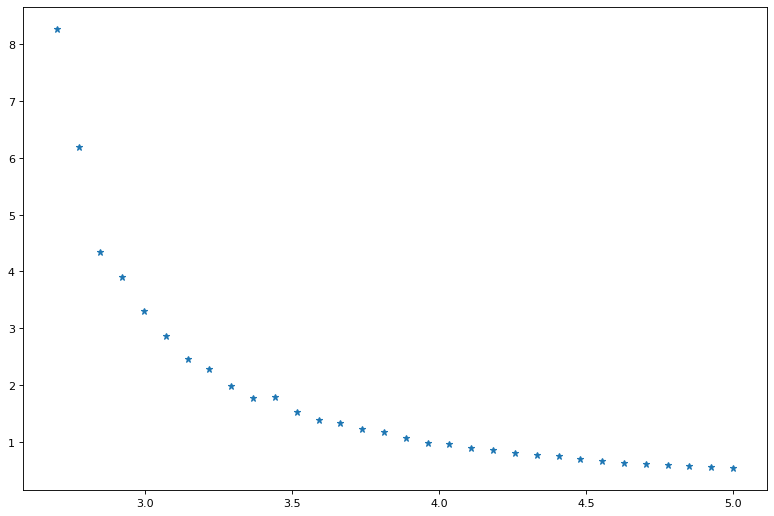

In [23]:
plt.plot(Ts, Xis, "*")

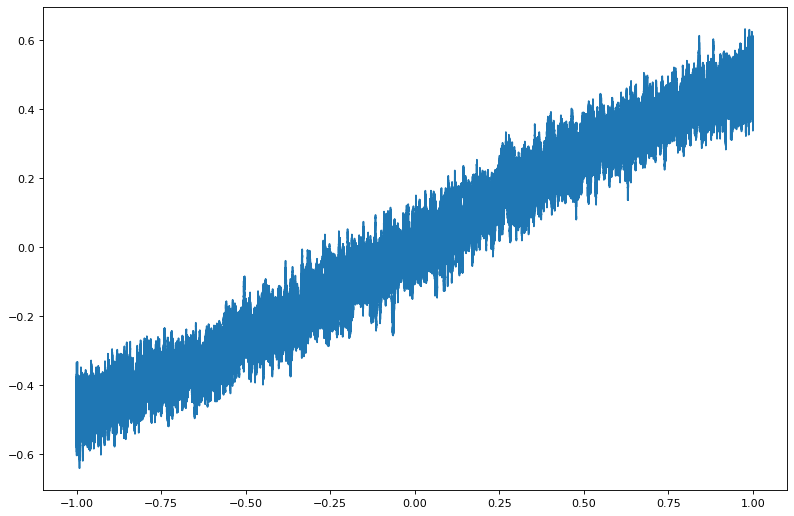

In [19]:
plt.plot(Hs, Ms)

In [12]:
%%time
STEPS, Ms, Hs = f(1, 4, 32, 1/500, periods=4, pass_high=1, pass_low=0)

13065070
CPU times: user 3.12 s, sys: 0 ns, total: 3.12 s
Wall time: 2.78 s


In [10]:
w=int(len(Ms)*0.001)
print(w)
st = w
Msma = moving_average(Ms, w, stride=st)
Hsma = moving_average(Hs, w, stride=st)

8300


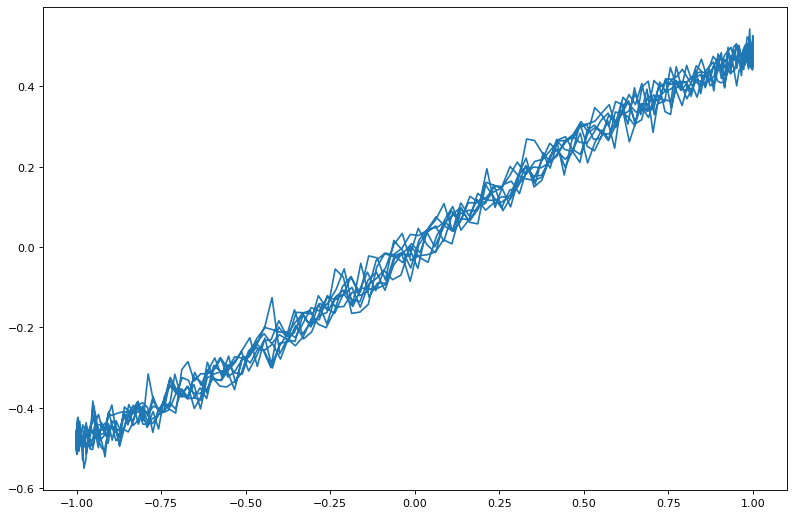

In [11]:
plt.plot(Hsma, Msma)

In [16]:
slopes = []
for m in np.linspace(0,1, 100)[10:]:
    keep = (np.abs(Msma) < m)
    
    p = np.polyfit(Hsma[keep], Msma[keep], deg=1)
    slopes.append(p[0])
#     plt.plot())

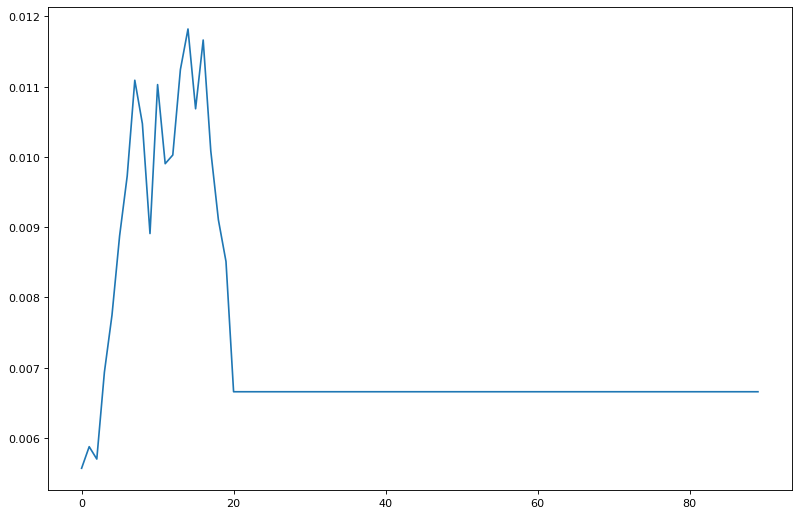

In [17]:
plt.plot(slopes)

In [18]:
beep()

In [43]:
ret

array([1.05878375e+00, 5.84647361e-04])

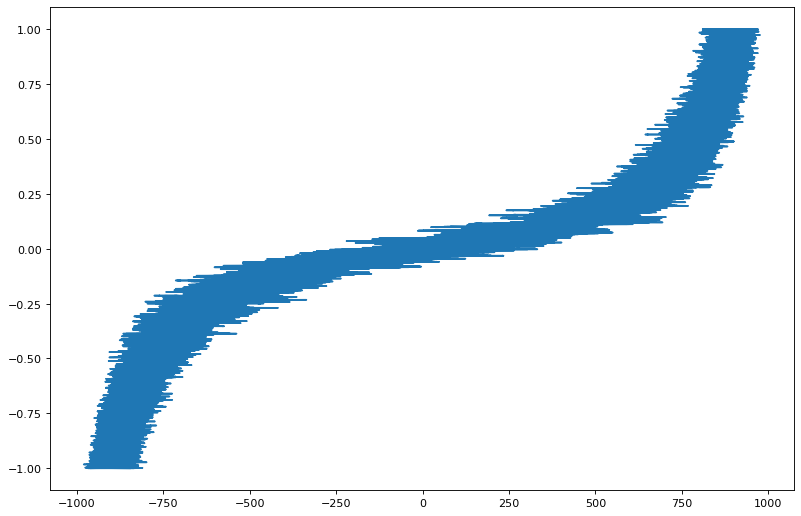

In [26]:
plt.plot(Ms, Hs)

39672000
29683


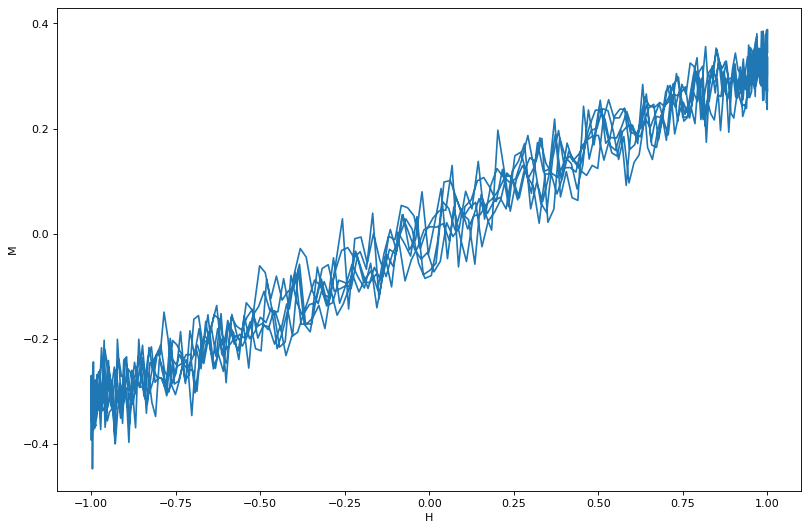

In [22]:
Ss, Ms, Hs = f(0.2, 3.5, 32, 1/1000,periods=3, pass_high=True)

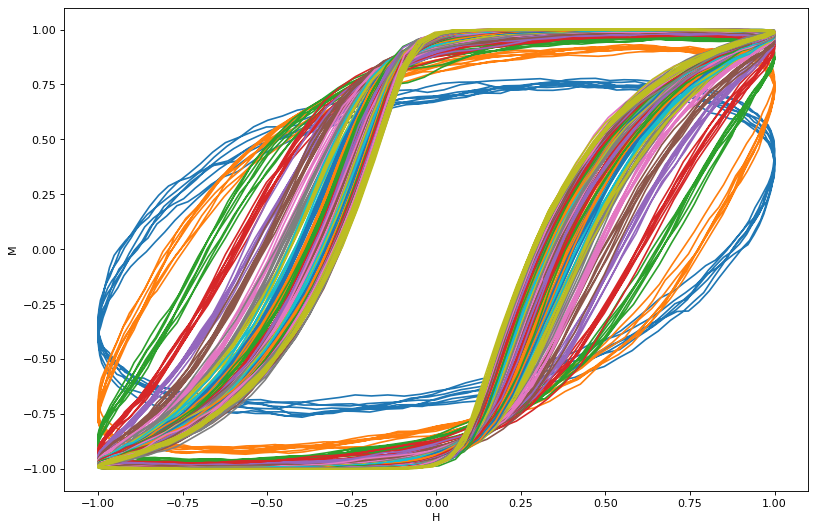

In [90]:
for H in range(1,30, 1):
    f(H, 3, 40, 1)

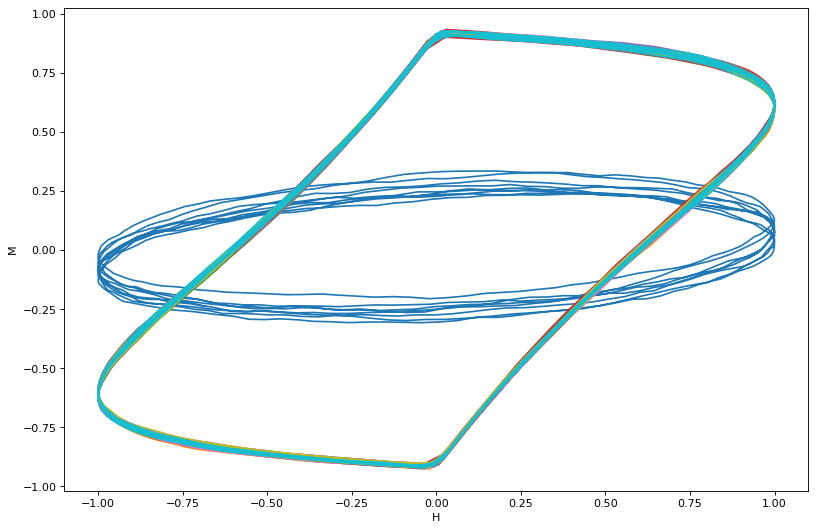

In [91]:
for H in tqdm(range(1,300000, 30000)):
    f(H, 4, 70, 1)
# plt.xlim(-10,10)

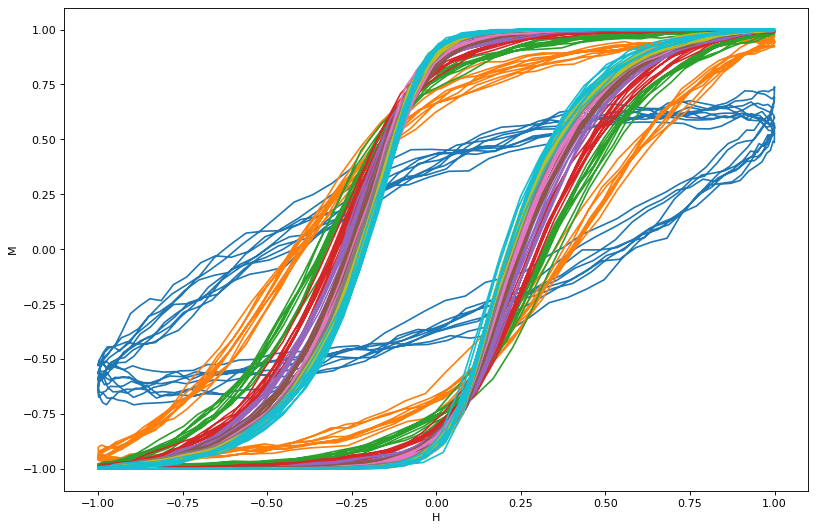

In [92]:
for H in tqdm(range(1,30, 3)):
    f(H, 4, 30, 1/5)
# plt.xlim(-10,10)

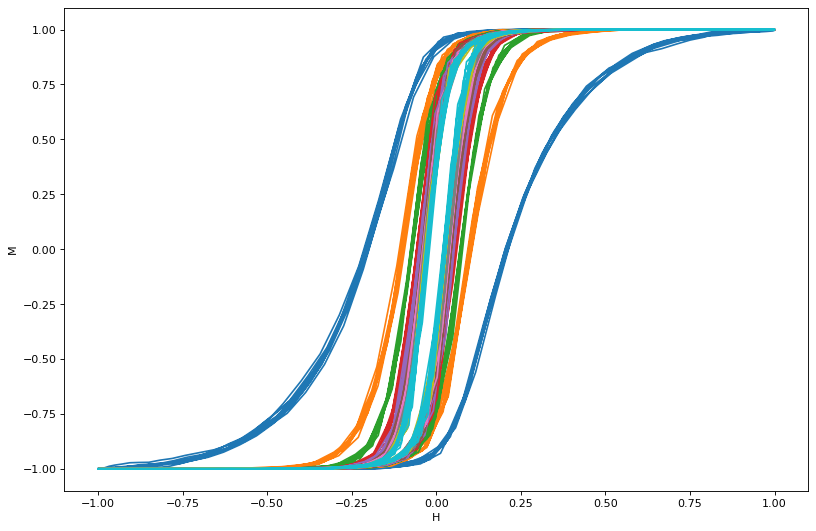

In [93]:
for H in tqdm(range(5,100, 10)):
    f(30, 4, 30, 1/H)